In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import datetime as dt
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from sktime.forecasting.arima import AutoARIMA
from sklearn.metrics import mean_squared_error
import numpy as np



from statsmodels.tsa.seasonal import seasonal_decompose

In [23]:
def load_data_csv(datapath):
    data = pd.read_csv(datapath)
    
    print(f"{datapath.split('/')[-1]} ||Shape :", data.shape)
    return data


train_df = load_data_csv(os.path.join(os.getcwd(),'EDA_train.csv'))
valid_df = load_data_csv(os.path.join(os.getcwd(),'EDA_valid.csv'))
test_df = load_data_csv(os.path.join(os.getcwd(),'EDA_test.csv'))
highways = train_df.columns[2:-1]

EDA_train.csv ||Shape : (3312, 37)
EDA_valid.csv ||Shape : (336, 38)
EDA_test.csv ||Shape : (336, 38)


# Data Set 분석

In [24]:
train_df['날짜'] = train_df['날짜'].astype('string')
train_df['시간'] = train_df['시간'].astype('string')
train_df['date'] = train_df['날짜']+train_df['시간']
train_df['date'] = pd.to_datetime(train_df['date'],format='%Y-%m-%d%H')
train_df =train_df.drop(labels=['날짜','시간'],axis=1)

In [25]:
valid_df['날짜'] = valid_df['날짜'].astype('string')
valid_df['시간'] = valid_df['시간'].astype('string')
valid_df['date'] = valid_df['날짜']+valid_df['시간']
valid_df['date'] = pd.to_datetime(valid_df['date'],format='%Y%m%d%H')
valid_df =valid_df.drop(labels=['날짜','시간'],axis=1)

In [26]:
highways

Index(['10', '100', '101', '120', '121', '140', '150', '160', '200', '201',
       '251', '270', '300', '301', '351', '352', '370', '400', '450', '500',
       '550', '600', '650', '652', '1000', '1020', '1040', '1100', '1200',
       '1510', '2510', '3000', '4510', '5510'],
      dtype='object')

In [27]:
Train_by_road = {}
Valid_by_road = {}
for i in highways:
    Train_by_road[i] = train_df.loc[:,['date',i]]
    Valid_by_road[i] = valid_df.loc[:,['date',i]]

In [28]:
train10 = Train_by_road['10'].set_index('date').asfreq('H')
valid10 = Valid_by_road['10'].set_index('date').asfreq('H')

# Decomposing Dataset

### ACF. PACF보기

In [29]:
def tsplot(data,name,save=False,lags=None,figsize=(30,15)):
    fig =  plt.figure(figsize=figsize)
    layout=(2,2)
    ts_ax = plt.subplot2grid(layout,(0,0),colspan=2)
    acf_ax = plt.subplot2grid(layout,(1,0))
    pacf_ax= plt.subplot2grid(layout,(1,1))
    
    data.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(data)[1]
    print(p_value)
    ts_ax.set_title(f'{name}th Highway Time Series plot\n Dickey-Fuller :p={0:.5f}'.format(p_value))
    sm.graphics.tsa.plot_acf(data,lags=lags,ax=acf_ax)
    sm.graphics.tsa.plot_pacf(data,lags=lags,ax=pacf_ax)
    plt.tight_layout()
    if save:
        plt.savefig(f'./acf/{name}.png')
    plt.show()

8.561482772636055e-11


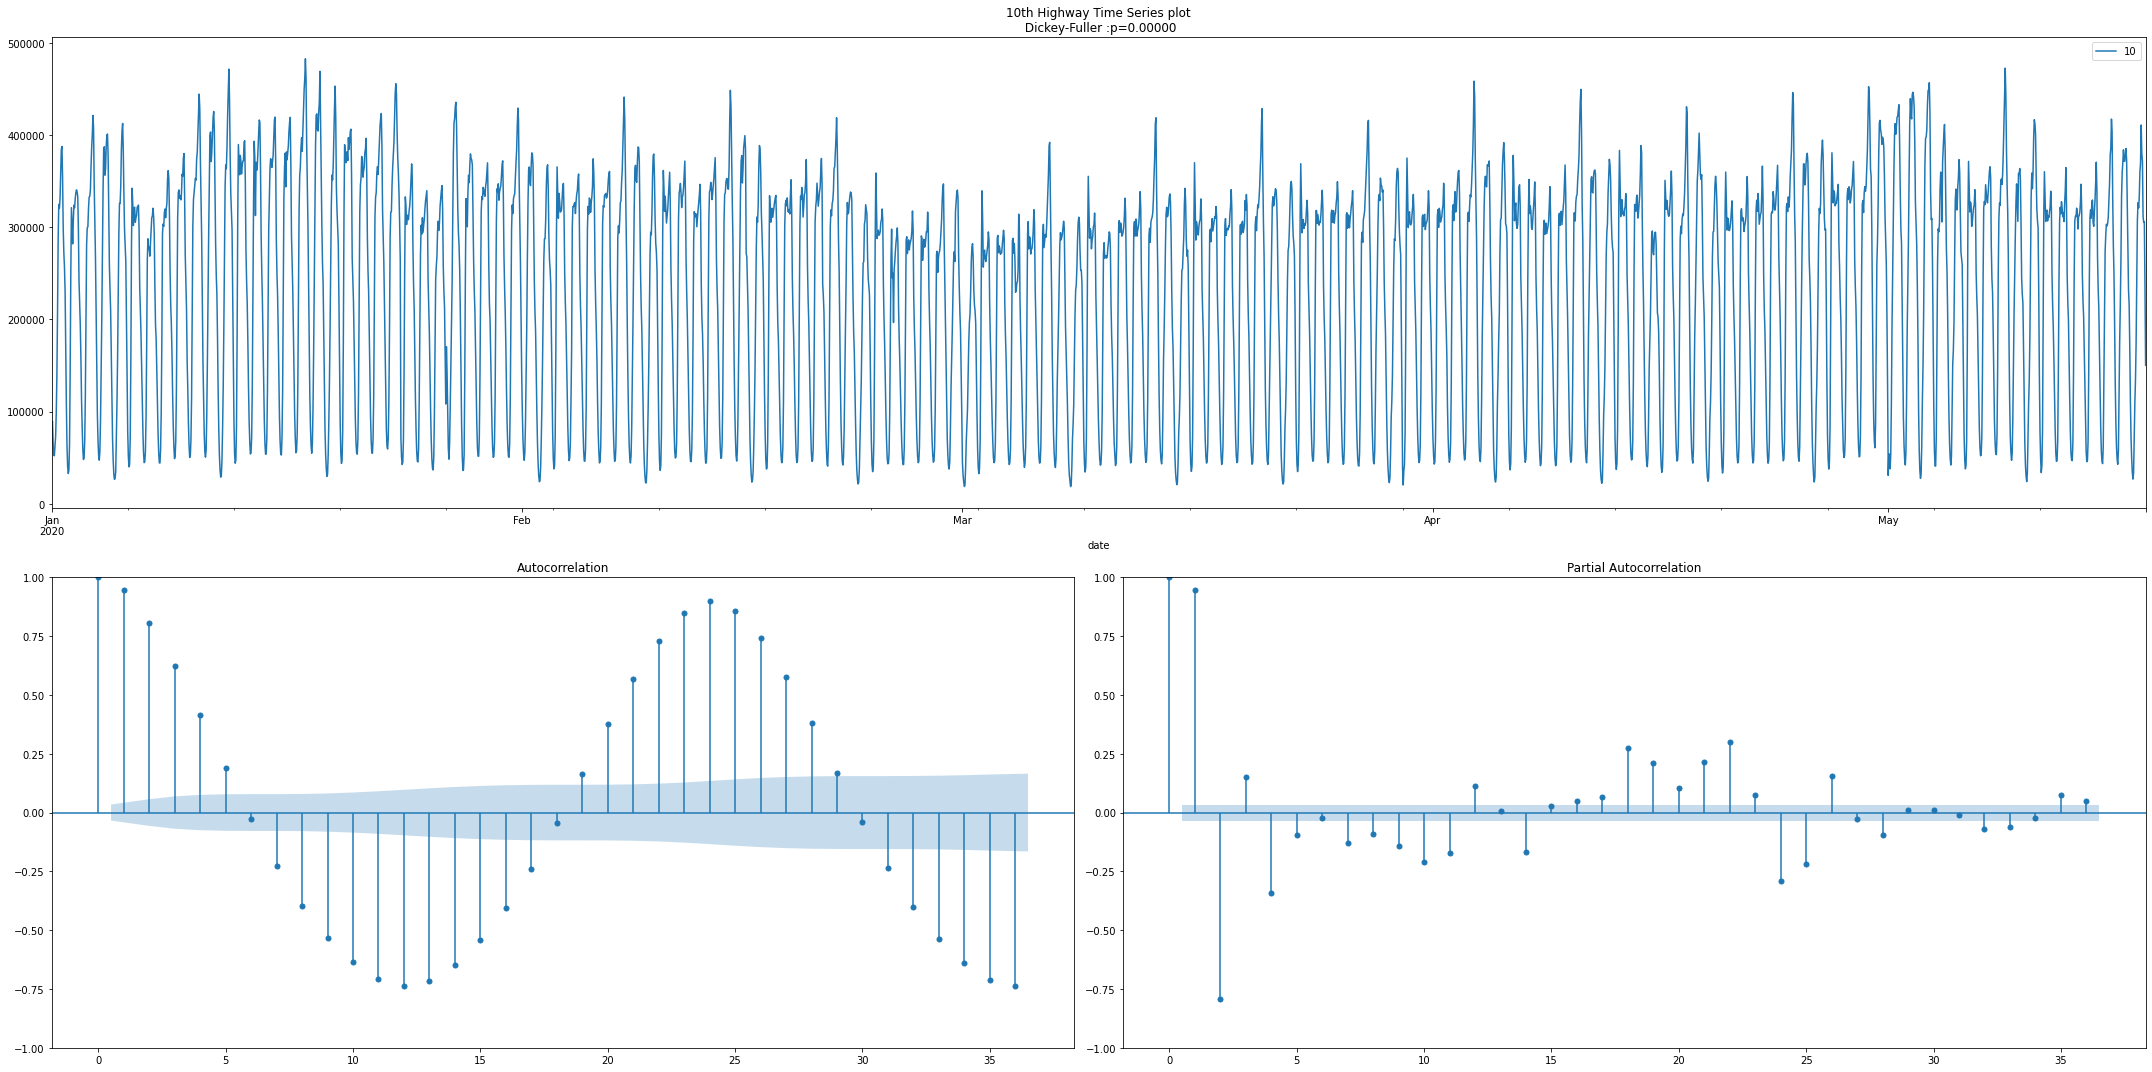

In [30]:
tsplot(train10,'10')

1.4061941211147982e-29


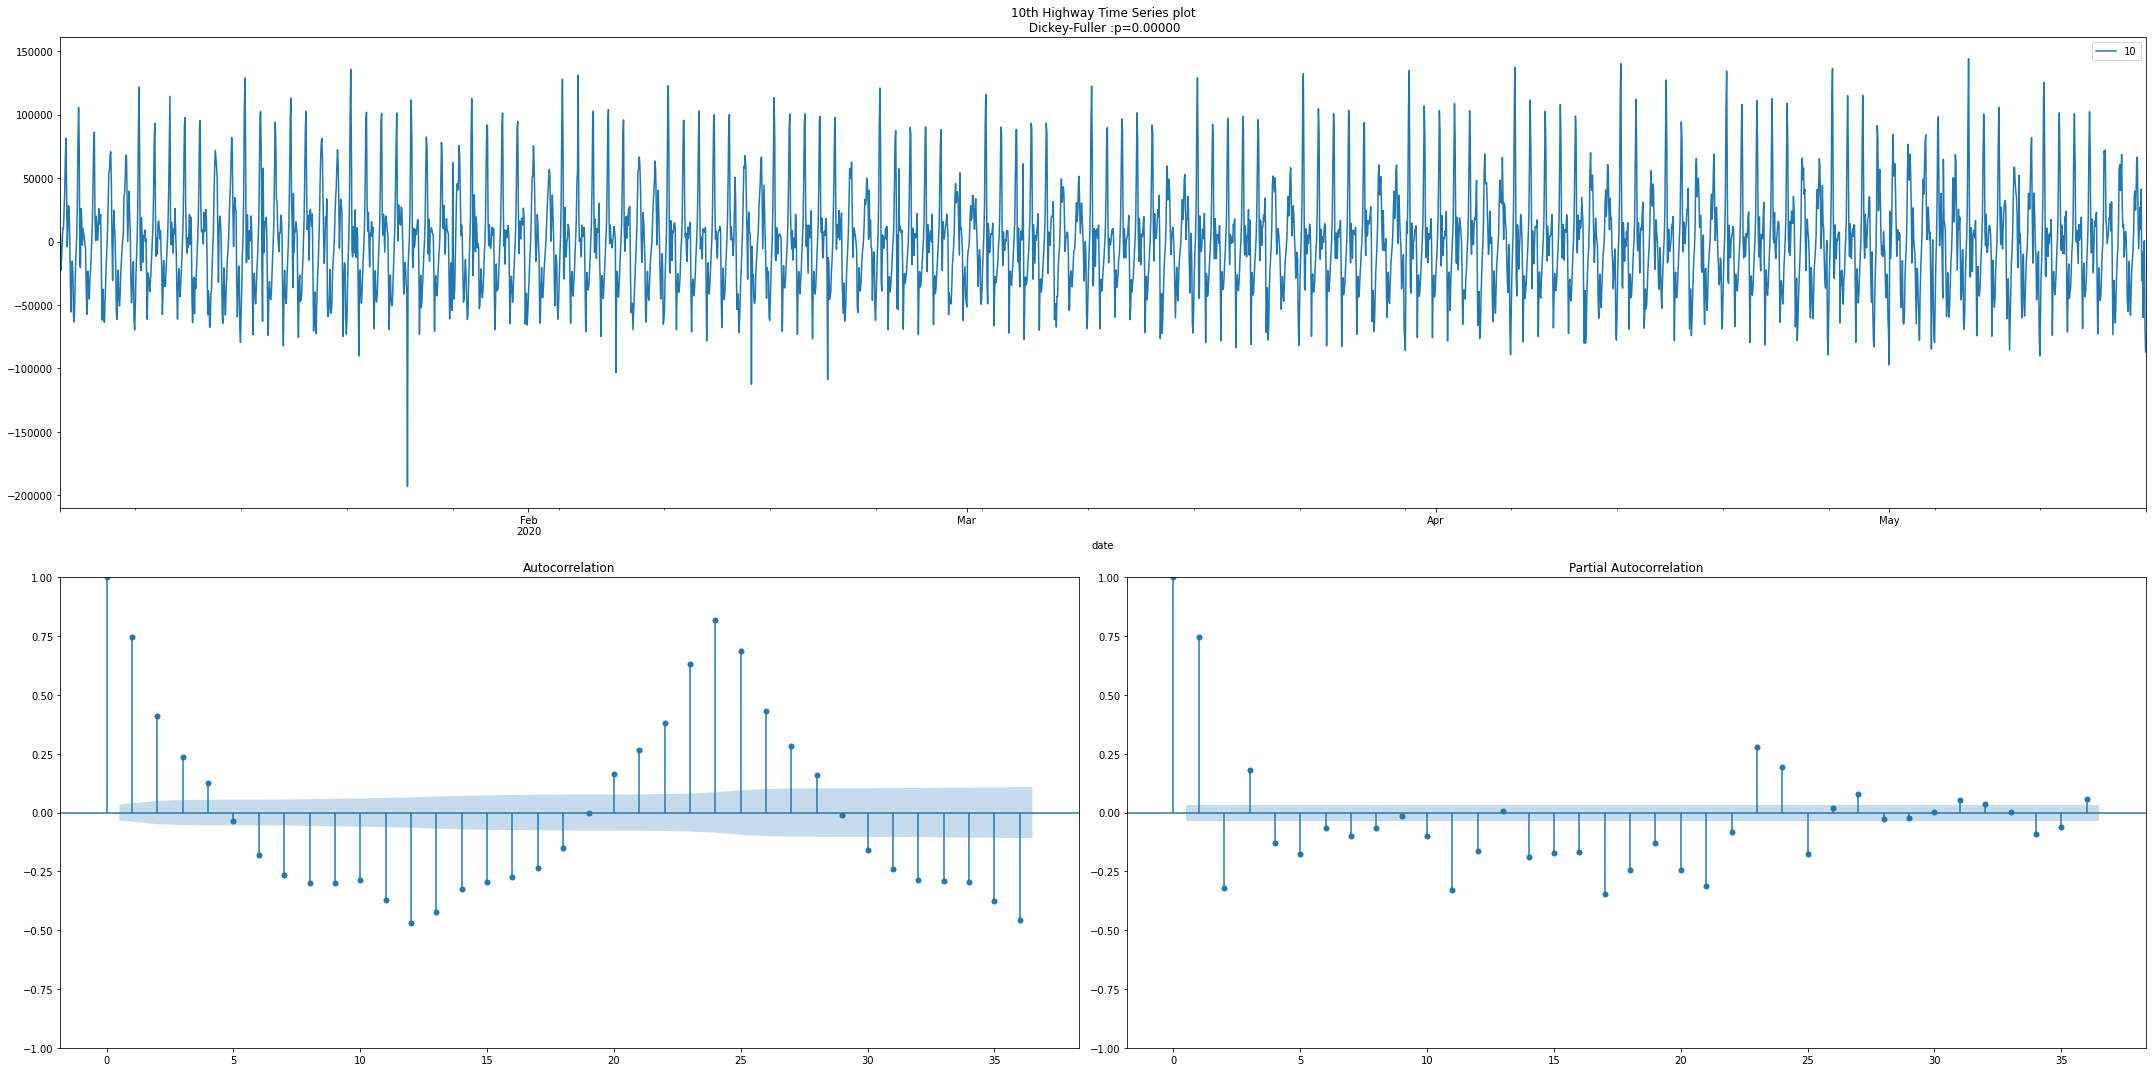

In [31]:
tsplot((train10-train10.shift(1)).dropna(),'10')

In [32]:
forcaster = AutoARIMA(start_p=7,max_p=16,suppress_warnings=True)
forcaster.fit(train10)
forcaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3312
Model:              SARIMAX(12, 0, 0)   Log Likelihood              -37589.965
Date:                Fri, 18 Feb 2022   AIC                          75207.931
Time:                        03:14:40   BIC                          75293.405
Sample:                             0   HQIC                         75238.522
                               - 3312                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.105e+04   2050.510     24.895      0.000     4.7e+04    5.51e+04
ar.L1          1.7653      0.011    158.511      0.000       1.743       1.787
ar.L2         -1.2719      0.021    -59.484      0.000      -1.314      -1.230
ar.L3          0.5776      0.031     18.658      0.000       0.517       0.638
ar.L4         -0.1133      0.039     -2.909      0.004      -0.190      -0.037
ar.L5         -0.1880      0.044     -4.261      0.000      -0.275      -0.102
ar.L6          0.0721      0.045      1.620      0.105      -0.015       0.159
ar.L7          0.0223      0.047      0.472      0.637      -0.070       0.115
ar.L8         -0.0370      0.046     -0.798      0.425      -0.128       0.054
ar.L9         -0.0175      0.047     -0.374      0.709      -0.109       0.074
ar.L10         0.2191      0.041      5.367      0.000       0.139       0.299
ar.L11        -0.3655      0.030    -12.047      0.000      -0.425      -0.306
ar.L12         0.1144      0.016      7.267      0.000       0.084       0.145
sigma2       4.22e+08      0.184    2.3e+09      0.000    4.22e+08    4.22e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               976.26
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.22
Prob(H) (two-sided):                  0.24   Kurtosis:                         5.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.78e+24. Standard errors may be unstable.
"""

In [38]:
def plot_forcast(series_train,series_valid,forcast,forcast_int=False):
    rmse = mean_squared_error(series_valid,forcast)
    
    fig =plt.figure(figsize=(30,15))
    plt.title(f"RMSE : {rmse:.4f}",size=25)
    
    ax = fig.add_subplot()
    
    ax.plot(series_train.loc['2020-05-10':],label='train',color='b')
    ax.plot(series_valid,label='valid',color='g')
    
    forcast.index = series_valid.index
    ax.plot(forcast,label='forcast',color='r')
    if forcast_int is not None:
        plt.fill_between(
            series_valid.index,
            forcast_int['lower'],
            forcast_int['upper'],
            alpha=.2,
            color='dimgray'
        )
    plt.legend(prop={'size':16})
    plt.show()
    
    return rmse

In [39]:
fh = np.arange(len(valid10))+1

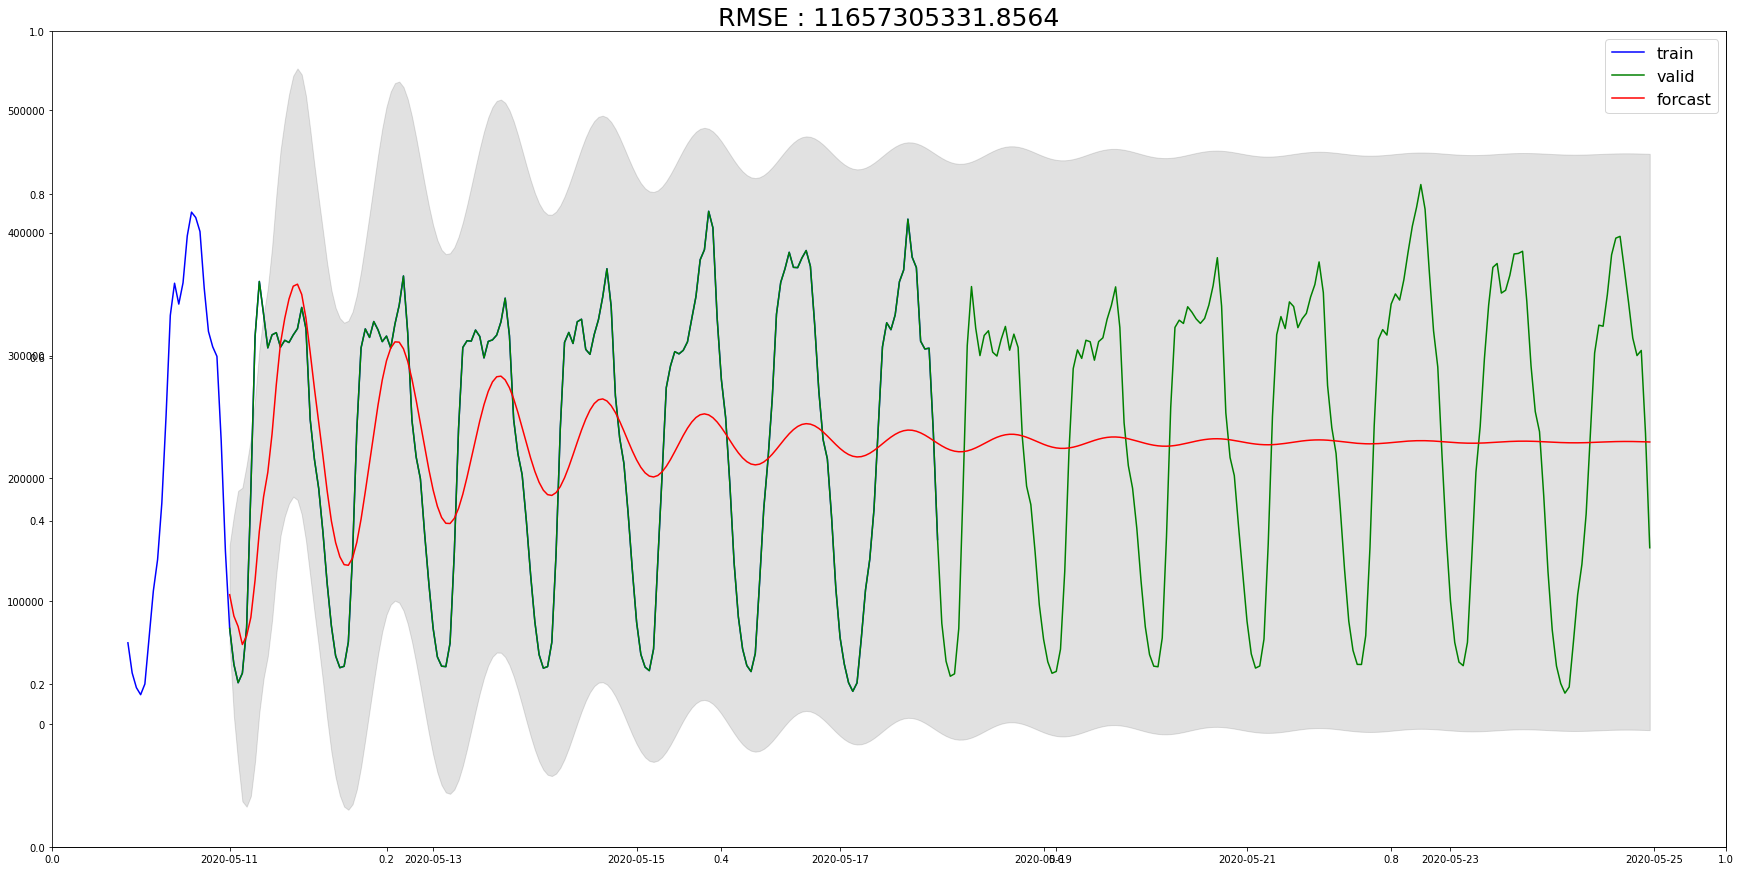

In [40]:
forcast, forcast_int = forcaster.predict(fh=fh,return_pred_int=True,alpha=.05)
train10_rmse = plot_forcast(train10,valid10,forcast,forcast_int)

# lightgbm 활용하기

In [43]:
from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster
from sktime.forecasting.model_selection import ExpandingWindowSplitter,ForecastingGridSearchCV
import lightgbm as lgb

In [44]:
def create_forcaster():
    
    regressor = lgb.LGBMRegressor()
    forcaster = make_reduction(regressor,window_length=10)
    
    return forcaster
    

In [45]:
def grid_search_forcaster(train,valid,forcaster,param_grid):
    
    cv = ExpandingWindowSplitter(initial_window=int(len(train)*0.7))
    gscv = ForecastingGridSearchCV(forcaster,strategy='refit',cv=cv,param_grid=param_grid,verbose=3)
    
    gscv.fit(train)
    print(f'Best param:{gscv.best_params_}')
    
    fh = np.arange(len(valid))+1
    y_pred = gscv.predict(fh=fh)
    rmse = plot_forcast(train,valid,y_pred)
    
    return rmse

In [ ]:
param_grid = {'window_length':[15,30]}
forcaster = create_forcaster()
lgb_rsme = grid_search_forcaster(train10,valid10,forcaster,param_grid)